## Import Modules

In [1]:
import os
import random
from tqdm import tqdm
import warnings
from typing import NoReturn, Union

import random
import pandas as pd
import numpy as np

import pywt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

## Read and Downcast Datasets (Texas, Store 2, Department 3, Product Food 586)

In [2]:
def get_memory_usage(df: pd.DataFrame) -> float:
    return df.memory_usage().sum() / 1024 ** 2

def downcast(df: pd.DataFrame) -> pd.DataFrame:
    start_memory = get_memory_usage(df)
    
    dtypes = df.dtypes.values.tolist()
    columns = df.columns.tolist()
    
    for dtype, column in zip(dtypes, columns):
        if dtype == np.object_:
            df[column] = df[column].astype('category')
        else:
            try:
                minimum = df[column].min()
                maximum = df[column].max()
                
                def try_types(types: list[str], function: str) -> NoReturn:
                    for sub_type in types:
                        info = getattr(np, function)(sub_type)

                        if minimum > info.min and maximum < info.max:
                            df[column] = df[column].astype(sub_type)
                            break
                
                str_dtype = str(dtype)
                
                if 'int' in str_dtype:
                    try_types(
                        types=['int8', 'int16', 'int32', 'int64'],
                        function='iinfo'
                    )
                elif 'float' in str_dtype:
                    try_types(
                        types=['float16', 'float32', 'float64'],
                        function='finfo'
                    )      
            except: continue
    
    end_memory = get_memory_usage(df)
    print(
        'Memory usage decreased from {:.3f} MB to {:.3f} MB'\
        .format(start_memory, end_memory)
    )
    return df

In [3]:
def read_datasets() -> list[pd.DataFrame]:
    calendar = downcast(
        pd.read_csv(
            filepath_or_buffer='datasets/calendar.csv',
            parse_dates=['date'],
        ).drop(columns=['snap_CA', 'snap_WI'])
    )
    sales = downcast(
        pd.read_csv('datasets/sales.csv')
    )
    prices = downcast(
        pd.read_csv('datasets/prices.csv')
    )
    return [calendar, sales, prices]

In [4]:
calendar, sales, prices = read_datasets()

Memory usage decreased from 0.180 MB to 0.122 MB
Memory usage decreased from 0.015 MB to 0.003 MB
Memory usage decreased from 0.009 MB to 0.002 MB


## Melt Time Series data in Column and Merge Datasets

In [5]:
sales_melt = pd.melt(
    frame=sales,
    id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
    var_name='day',
    value_name='demand'
)
tx2 = pd.merge(
    left=sales_melt, right=calendar,
    how='left',
    left_on='day', right_on='d'
)
tx2 = pd.merge(
    left=tx2, right=prices,
    how='left',
    on=['item_id', 'store_id', 'wm_yr_wk'],
)
tx2.day = tx2.day.apply(
    lambda day: int(day.split('_')[-1])
)
tx2.drop(
    columns=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'wm_yr_wk', 'd'],
    inplace=True
)

In [6]:
tx2

,day,demand,date,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,sell_price
0,1,98,2011-01-29,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,1.480469
1,2,85,2011-01-30,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,1.480469
2,3,47,2011-01-31,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,1.480469
3,4,56,2011-02-01,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1.480469
4,5,51,2011-02-02,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,0,1.480469
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,1937,76,2016-05-18,Wednesday,5,5,2016,NaN,NaN,NaN,NaN,0,1.679688
1937,1938,53,2016-05-19,Thursday,6,5,2016,NaN,NaN,NaN,NaN,0,1.679688
1938,1939,96,2016-05-20,Friday,7,5,2016,NaN,NaN,NaN,NaN,0,1.679688
1939,1940,79,2016-05-21,Saturday,1,5,2016,NaN,NaN,NaN,NaN,0,1.679688


## Base EDA

### Sum of Price and Demand for Each Day

In [7]:
tx2_day = tx2.set_index('date')[['demand', 'sell_price']]

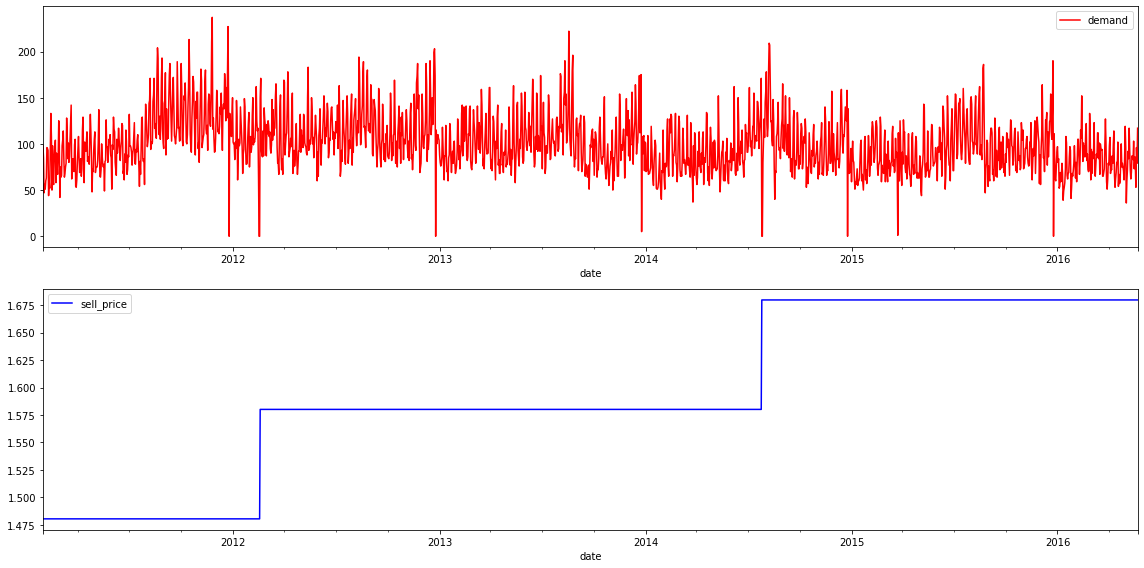

In [8]:
figure, axes = plt.subplots(nrows=2, figsize=(16, 8))

tx2_day.plot(y='demand', color='red', ax=axes[0])
tx2_day.plot(y='sell_price', color='blue', ax=axes[1])

plt.tight_layout()

### Mean of Price and Demand for Event Days

In [9]:
events = tx2[tx2.event_name_1.notna()]
tx2_events = events.groupby('event_name_1')[['demand', 'sell_price']].agg('mean')
idxs = np.arange(tx2_events.shape[0])

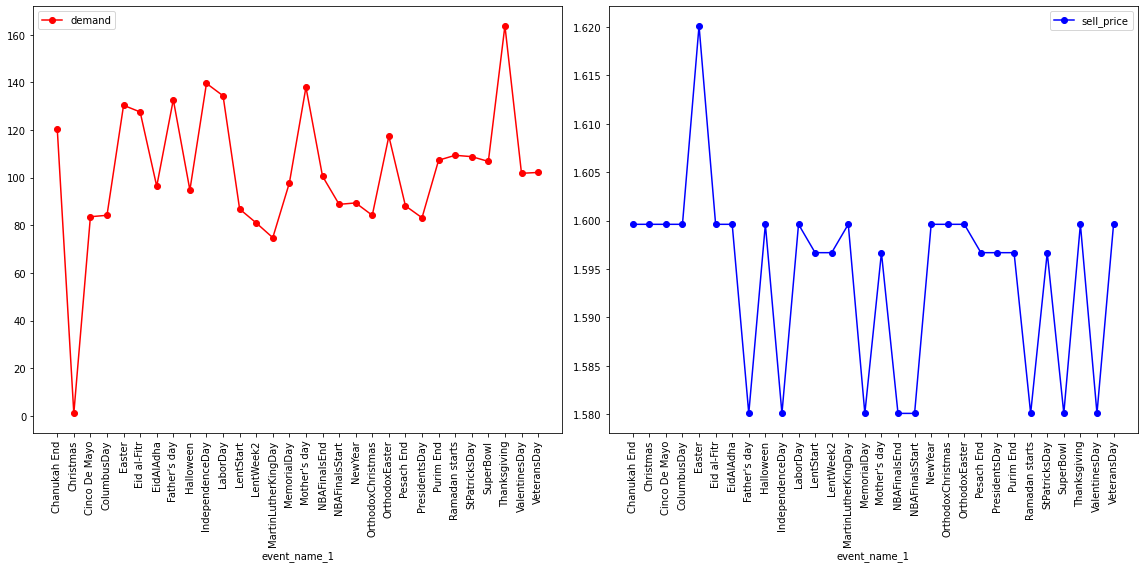

In [10]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 8))

tx2_events.plot(y='demand', color='red', marker='o', ax=ax1)
ax1.set_xticks(idxs)
ax1.set_xticklabels(tx2_events.index, rotation=90)

tx2_events.plot(y='sell_price', color='blue', marker='o', ax=ax2)
ax2.set_xticks(idxs)
ax2.set_xticklabels(tx2_events.index, rotation=90)

plt.tight_layout()

### Seasonal Decomposition

In [11]:
decomposition = sm.tsa.seasonal_decompose(tx2[['demand', 'date']].set_index('date'))

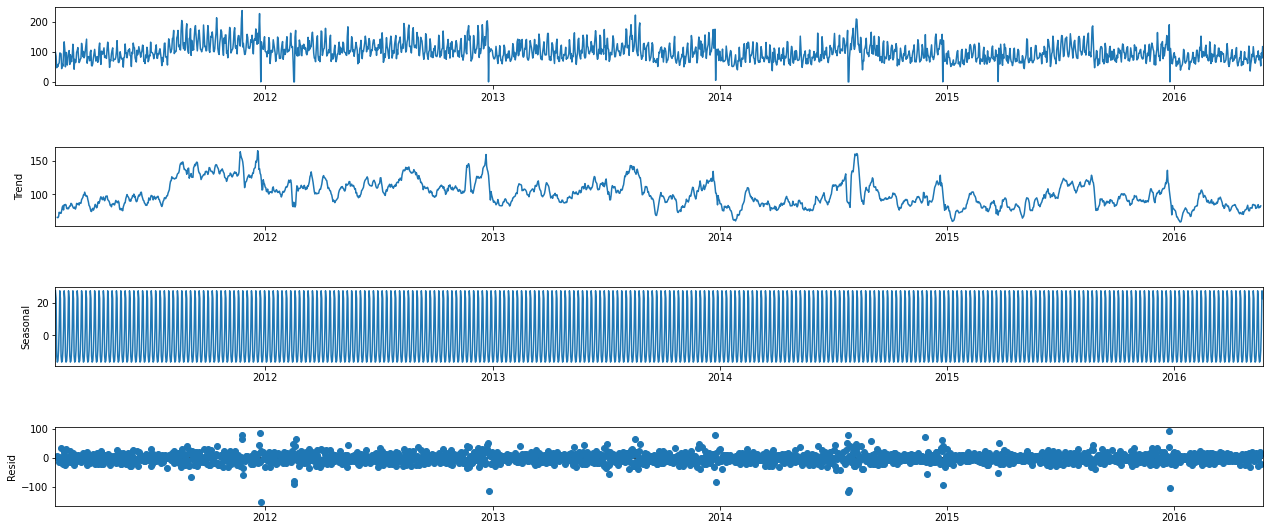

In [12]:
fig = decomposition.plot()
fig.set_figwidth(20)
fig.set_figheight(8)

### Stationarity Test

In [13]:
test_result = sm.tsa.adfuller(tx2.demand, regression='ct')

In [14]:
display(f'ADF Value: {test_result[0]}')
display(f'P-value: {test_result[1]}')

for alpha, critical in test_result[4].items():
	display(f'{alpha}: {critical}')

'ADF Value: -4.94984352975133'

'P-value: 0.00025366060867279257'

'1%: -3.9635077164498274'

'5%: -3.4127863079356895'

'10%: -3.128401962794301'

## Denoising

In [15]:
noise_data = tx2.demand[184:364].reset_index(drop=True)

In [16]:
def plot_smoothing(denoised_data: np.ndarray) -> NoReturn:
    plt.figure(figsize=(16, 8))

    plt.plot(noise_data, color='lightblue')
    plt.plot(denoised_data, color='red')

    plt.show()

### Average Smoothing

In [17]:
def average_smoothing(data: np.ndarray, kernel_size: int) -> np.ndarray:
    
    kernel = np.ones(kernel_size) / kernel_size
    smoothed = np.convolve(data, kernel, mode='same')
    
    return smoothed

In [18]:
smoothed = average_smoothing(noise_data, 4)

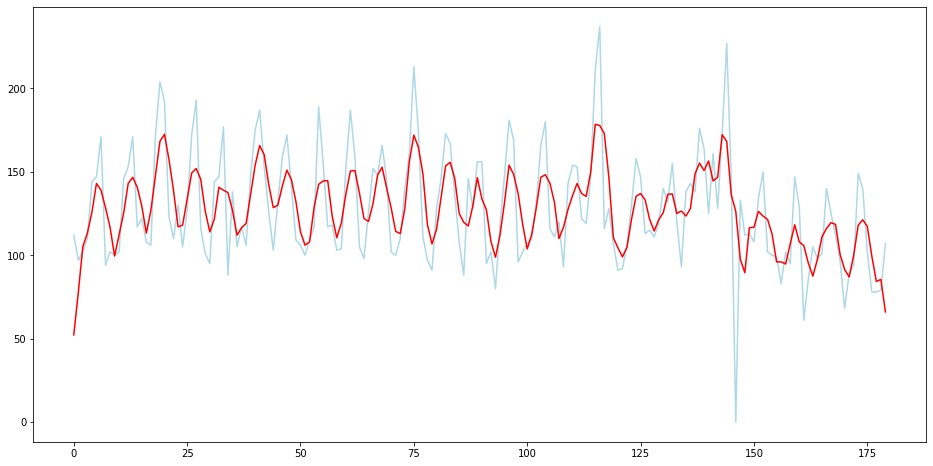

In [19]:
plot_smoothing(smoothed)

### Wavelet Transform

In [20]:
def compute_mad(data: np.ndarray, axis: int = None) -> float:
    
    mad = np.mean(np.absolute(data - np.mean(data, axis)), axis)
    return mad

def wavelet_denoising(data: np.ndarray, wavelet: str = 'db4', level: int = 1) -> np.ndarray:
    
    coeffs = pywt.wavedec(data, wavelet, mode="per")
    sigma = (1/0.6745) * compute_mad(coeffs[-level])
    
    threshold = sigma * np.sqrt(2 * np.log(len(data)))
    coeffs[1:] = [pywt.threshold(value, value=threshold, mode='hard') for value in coeffs[1:]]
    
    denoised = pywt.waverec(coeffs, wavelet, mode='per')
    return denoised

In [21]:
denoised = wavelet_denoising(noise_data, wavelet='bior3.1')

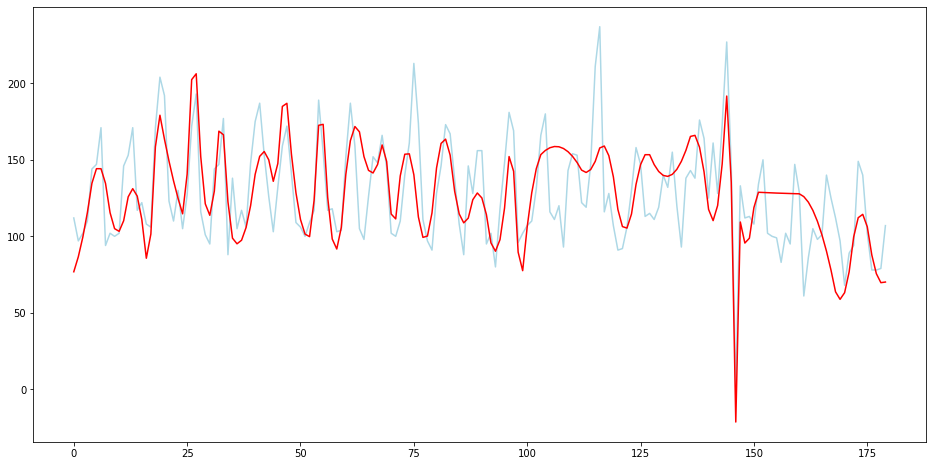

In [22]:
plot_smoothing(denoised)

### Fourier Transform

In [23]:
def fft_denoising(data: np.ndarray, threshold: float = 1e8) -> np.ndarray:
    fourier = np.fft.rfft(data)
    frequences = np.fft.rfftfreq(data.size, d=1e-5)
    
    fourier[frequences > threshold] = 0
    denoised = np.fft.irfft(fourier)
    
    return denoised

In [24]:
denoised = fft_denoising(noise_data, threshold=1.42e4)

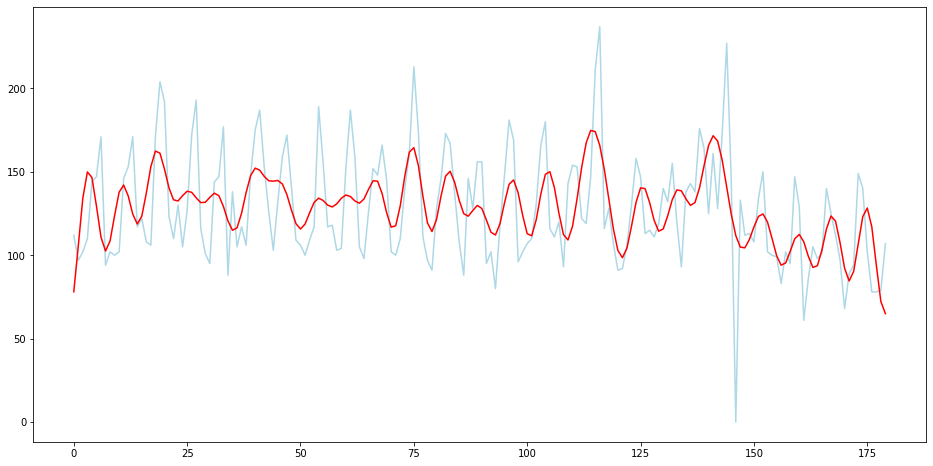

In [25]:
plot_smoothing(denoised)

## Simple Models

In [26]:
forecast_period = 28
valid = tx2[['demand', 'date']].iloc[-forecast_period:]
train = tx2[['demand', 'date']].iloc[:-forecast_period]

In [27]:
def plot_prediction(prediction: np.ndarray, target: pd.Series = valid, train: pd.Series = train, last: int = 90):
    plt.figure(figsize=(16, 6))
    plt.xticks(rotation=45)
    
    plt.ylabel('Demand')
    plt.xlabel('Date')
    
    if train is not None:
        train = train[-last:] if last else train
        plt.plot(
            'date', 'demand', data=train,
            color='green',
            label='train'
        )       
    plt.plot(
        target.date, prediction,
        color='red',
        label='predicion'
    )
    plt.plot(
        'date', 'demand', data=target,
        color='blue',
        label='target'
    )
    print('MSE:', mean_squared_error(target.demand, prediction))

### Holt

MSE: 493.59090128903955


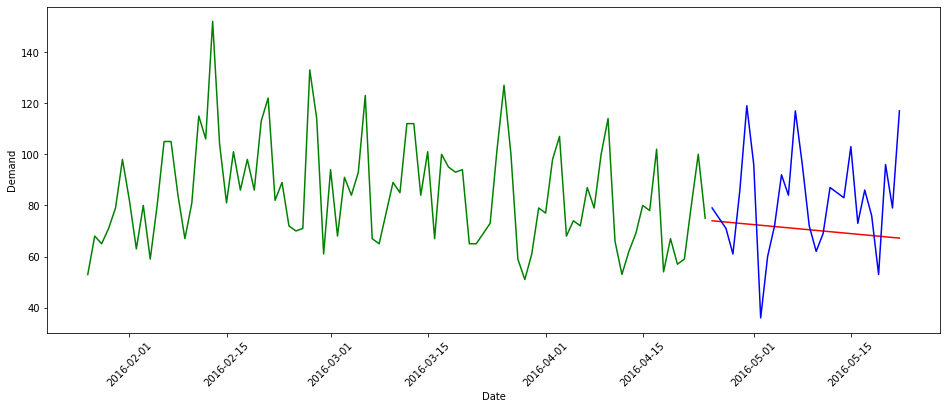

In [28]:
holt = sm.tsa.Holt(train.demand).fit()
holt_pred = holt.forecast(forecast_period)
plot_prediction(holt_pred)

### Double Exponential Smoothing

MSE: 325.3435383725096


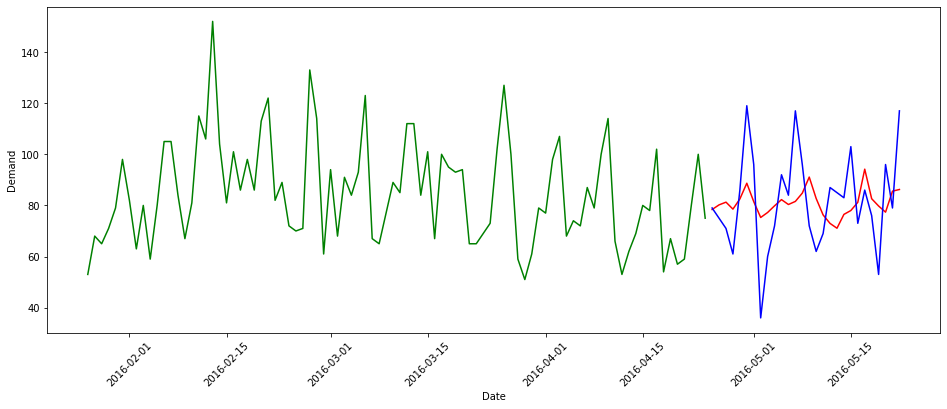

In [29]:
exp = sm.tsa.ExponentialSmoothing(train.demand, seasonal='add', seasonal_periods=52).fit()
exp_pred = exp.forecast(forecast_period)
plot_prediction(exp_pred)

### ARIMA

MSE: 208.01332603875713


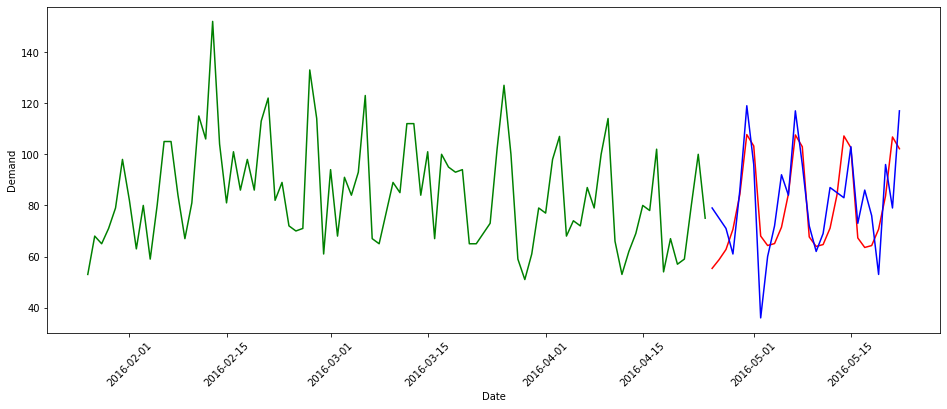

In [30]:
arima = sm.tsa.SARIMAX(train.demand, order=(1, 1, 1), seasonal_order=(0, 1, 1, 7), trend='c').fit()
arima_pred = arima.forecast(forecast_period)
plot_prediction(arima_pred)

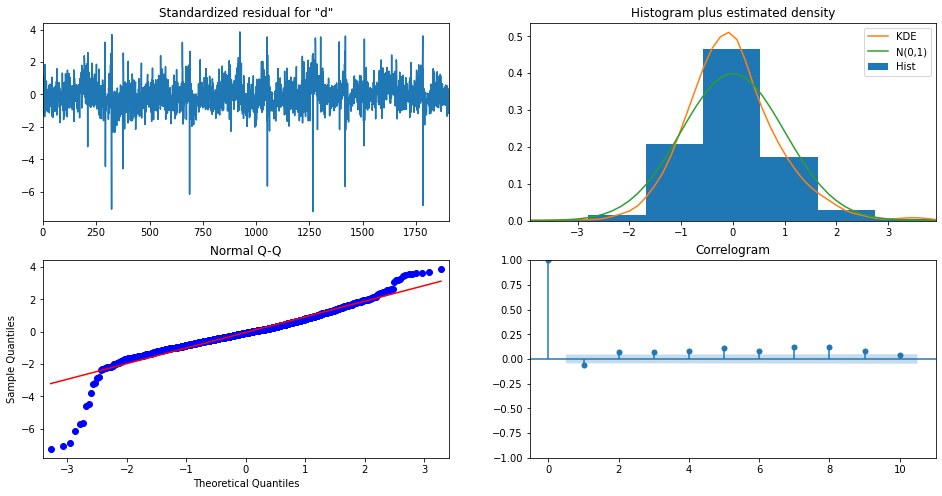

In [31]:
arima.plot_diagnostics(figsize=(16, 8))
plt.show()

## Seq2seq

### Config

In [126]:
SEED = 2021 
DEVICE = 'cuda'

EPOCHS = 500
TRAIN_WINDOW = 90
PREDICT_WINDOW = 28

TRAIN_BATCH_SIZE = 64
VALID_BATCH_SIZE = 64

NUM_FEATURES = 24
HIDDEN_DIM = 64

### Make Deterministic

In [33]:
def make_deterministic(seed: int) -> NoReturn:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [34]:
make_deterministic(SEED)

### Generate Features

### Remove Seasonality

In [35]:
def difference(data, interval):
    return np.array(list(data[:interval]) + [data[i] - data[i - interval] for i in range(interval, len(data))])

In [36]:
tx2['interval'] = tx2.demand
tx2['demand'] = difference(tx2.interval, 7)

#### Lag

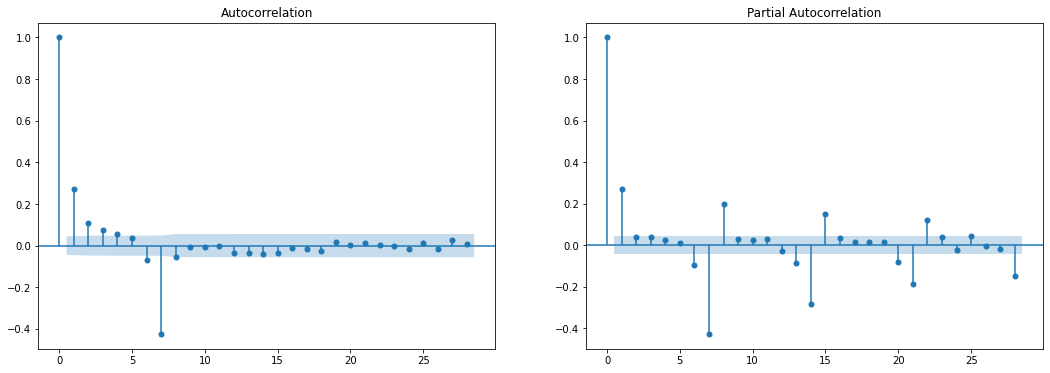

In [37]:
figure, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))
lags = 28

plot_acf(tx2.demand, lags=lags, ax=ax1)
plot_pacf(tx2.demand, lags=lags, ax=ax2)

plt.show()

In [38]:
def add_lags(data: pd.DataFrame, column: str, lags: list[int]) -> pd.DataFrame:
    df = data.copy()
    for lag in lags:
        df[f'lag_{lag}'] = df[column].shift(lag)
    return df

In [39]:
tx2 = add_lags(tx2, 'demand', [1, 7, 14, 21, 28])

#### Rolling Mean

In [40]:
def add_rolling_mean(data: pd.DataFrame, column: str, windows: list[int], shift: int = None):
    df = data.copy()
    for window in windows:
        df[f'rolling_mean_{window}'] = (
            df[column].shift(shift) if shift is not None 
            else df[column]
        ).rolling(window).mean()
    return df

In [41]:
tx2 = add_rolling_mean(tx2, 'demand', [7, 14, 28, 60, 90, 180, 365], 28)

#### Time and Domain Specific

In [42]:
tx2['day'] = tx2.date.dt.day
tx2['event'] = tx2.event_name_1.notna().astype('int8')

#### Select and Process Features

In [43]:
tx2.drop(columns=['date', 'weekday', 'interval'], inplace=True)

for column, dtype in tx2.dtypes.iteritems():
    if str(dtype) == 'category':
        tx2[column] = tx2[column].cat.codes
        
tx2.fillna(0, inplace=True)

In [44]:
tx2

,day,demand,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_TX,...,lag_21,lag_28,rolling_mean_7,rolling_mean_14,rolling_mean_28,rolling_mean_60,rolling_mean_90,rolling_mean_180,rolling_mean_365,event
0,29,98,1,1,2011,-1,-1,-1,-1,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,30,85,2,1,2011,-1,-1,-1,-1,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
2,31,47,3,1,2011,-1,-1,-1,-1,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,1,56,4,2,2011,-1,-1,-1,-1,1,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
4,2,51,5,2,2011,-1,-1,-1,-1,0,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936,18,7,5,5,2016,-1,-1,-1,-1,0,...,14.0,-5.0,-7.714286,-4.857143,-2.642857,-2.700000,-0.433333,-0.727778,-0.098630,0
1937,19,-34,6,5,2016,-1,-1,-1,-1,0,...,2.0,-10.0,-6.571429,-6.142857,-2.035714,-3.166667,-0.700000,-0.688889,-0.158904,0
1938,20,11,7,5,2016,-1,-1,-1,-1,0,...,6.0,0.0,-6.714286,-6.285714,-2.285714,-3.183333,-0.577778,-0.494444,-0.197260,0
1939,21,-4,1,5,2016,-1,-1,-1,-1,0,...,19.0,22.0,-0.428571,-4.857143,-2.714286,-2.616667,-0.244444,-0.461111,-0.216438,0


### Normalize Data

In [45]:
scaler = MinMaxScaler(feature_range=(-1, 1))
tx2_norm = pd.DataFrame(
    data=scaler.fit_transform(tx2),
    columns=tx2.columns
)

### Split Data

In [46]:
num_samples = tx2_norm.shape[0]
test_size = 28

train_size = int((num_samples - test_size) * 0.8)
valid_size = num_samples - train_size - test_size

train = tx2_norm.iloc[:train_size]
valid = tx2_norm.iloc[-valid_size:-test_size]

### Walmart Dataset

In [63]:
def sliding_window(features: np.ndarray, targets: np.ndarray, train_window: int, predict_window: int) -> tuple[np.ndarray, np.ndarray]:
    size = targets.size - train_window - predict_window
    if size <= 0: raise Exception('Invalid parameters')
        
    num_features = features.shape[1]

    seq_features = np.empty((size, train_window, num_features))
    seq_targets = np.empty((size, predict_window))
    seq_start = np.empty(size)

    for start in range(targets.size):
        bound = start + train_window
        end = bound + predict_window

        if end >= targets.size: break

        seq_features[start] = features[start:bound]
        seq_targets[start] = targets[bound:end]
        seq_start[start] = targets[bound - 1]

    return seq_features, seq_targets, seq_start

In [64]:
class WalmartDataset(Dataset):
    
    def __init__(self, features: np.ndarray, targets: np.array, train_window: int, predict_window: int) -> NoReturn:
        self.features, self.targets, self.starts = sliding_window(
            features=features,
            targets=targets,
            train_window=train_window,
            predict_window=predict_window
        )
    
    def __len__(self) -> int:
        return self.targets.shape[0]
    
    def __getitem__(self, idx: int) -> dict[str, torch.Tensor]:
        features = self.features[idx]
        targets = self.targets[idx]
        start = self.starts[idx]
        
        sample = {
            'features': torch.tensor(features, dtype=torch.float),
            'targets': torch.tensor(targets, dtype=torch.float),
            'start': torch.tensor(start, dtype=torch.float)
        }
        return sample

### Encoder

In [65]:
class Encoder(nn.Module):
    
    def __init__(self, num_features: int, hidden_dim: int) -> NoReturn:
        super().__init__()
        
        self.gru = nn.GRU(
            input_size=num_features,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
        )
        
    def forward(self, features) -> torch.Tensor:
        
        output, hidden = self.gru(features)
        hidden = hidden.squeeze()
        
        return output, hidden

### Attention

In [66]:
class Attention(nn.Module):
    
    def __init__(self, hidden_dim: int) -> NoReturn:
        super().__init__()
        
        self.linear1 = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=hidden_dim,
        )
        self.linear2 = nn.Linear(
            in_features=hidden_dim,
            out_features=1,
            bias=False
        )
        
    def forward(self, encoder, hidden) -> torch.Tensor:
        seq_len = encoder.size(1)
        
        hidden = hidden.unsqueeze(1)
        hidden = hidden.repeat(1, seq_len, 1)
        
        combined = torch.cat([hidden, encoder], dim=2)
        output = self.linear1(combined)
        output = torch.tanh(output)
        
        scores = self.linear2(output)
        scores = scores.squeeze()
        
        return F.softmax(scores, dim=1)

### Decoder

In [67]:
class Decoder(nn.Module): 
    
    def __init__(self, hidden_dim: int, attention: nn.Module):
        super().__init__()
        
        self.gru = nn.GRUCell(
            input_size=1,
            hidden_size=hidden_dim
        )
        self.linear = nn.Linear(
            in_features=hidden_dim * 2,
            out_features=1
        )
        self.attention = attention
        
    def forward(self, inputs, hidden, encoder) -> torch.Tensor:
        inputs = inputs.unsqueeze(1)
        new_hidden = self.gru(inputs, hidden)
        
        attention = self.attention(encoder, new_hidden)
        attention = attention.unsqueeze(1)
        
        context = torch.bmm(attention, encoder)
        context = context.squeeze()

        combined = torch.cat([context, new_hidden], dim=1)
        
        output = self.linear(combined).squeeze()
        return new_hidden, output

### Average Meter

In [68]:
class AverageMeter:
    def __init__(self, name: str = None) -> NoReturn:
        self.name = name
        self.reset()

    def update(self, values: Union[float, np.ndarray], count: int = 1) -> NoReturn:
        self.values = values
        self.sum += values * count
        self.count += count
        self.average = self.sum / self.count

    def reset(self) -> NoReturn:
        self.values = 0
        self.sum = 0
        self.count = 0
        self.average = 0

### Compute Metrics

In [109]:
def compute_metrics(logits: torch.Tensor, targets: torch.Tensor) -> float:
    logits = logits.detach().cpu().numpy()
    targets = targets.detach().cpu().numpy()
    rmse = np.sqrt(mean_squared_error(targets, logits))
    return {'rmse': rmse}

### Train function

In [110]:
def train_batch(batch, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, encoder_scheduler, device='cuda'):
    
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    features = batch['features'].to(device)
    targets = batch['targets'].to(device)
    inputs = batch['start'].to(device)

    encoder_hidden, decoder_hidden = encoder(features)
    seq_len = targets.size(1)
    
    outputs, loss = [], 0
    for idx in range(seq_len):
        
        decoder_hidden, logits = decoder(
            inputs=inputs,
            hidden=decoder_hidden,
            encoder=encoder_hidden,
        )      
        inputs = targets[:, idx]

        loss += criterion(logits, targets[:, idx])
        outputs.append(logits.detach().cpu())
    
    loss.backward()
    
    encoder_optimizer.step()
    decoder_optimizer.step()
    
    outputs = torch.stack(outputs, dim=1)
    metrics = compute_metrics(outputs, targets)
    
    return outputs, loss.item(), metrics

In [111]:
def train_epoch(data_loader, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, encoder_scheduler = None, decoder_scheduler = None, device='cuda') -> float: 
    losses = AverageMeter("Train Loss")   
    encoder.train(); decoder.train()
    
    loader = tqdm(data_loader, total=len(data_loader))
    for batch_idx, batch in enumerate(loader):
        
        outputs, loss, metrics = train_batch(batch, encoder, decoder, criterion, encoder_optimizer, decoder_optimizer, device)
        batch_size = outputs.shape[0]
        
        if encoder_scheduler is not None:
            encoder_scheduler.step(loss)
            
        if decoder_scheduler is not None:
            decoder_scheduler.step(loss)
        
        if batch_idx == 0:
            meters = {name: AverageMeter() for name in metrics}
        
        monitor = dict()
        for name in meters.keys():
            
            meters[name].update(metrics[name], batch_size)
            monitor[name] = meters[name].average
        
        losses.update(loss, batch_size)
        loader.set_postfix(mode='train', loss=losses.average, **monitor)
    
    loader.close()
    return losses.average

### Validate Function

In [118]:
def validate_batch(batch, encoder, decoder, criterion, device='cuda'):
    
    features = batch['features'].to(device)
    targets = batch['targets'].to(device)
    inputs = batch['start'].to(device)
    
    with torch.no_grad():
        encoder_hidden, decoder_hidden = encoder(features)
        seq_len = targets.size(1)
    
        outputs, loss = [], 0
        for idx in range(seq_len):
            
            decoder_hidden, logits = decoder(
                inputs=inputs,
                hidden=decoder_hidden,
                encoder=encoder_hidden,
            )
            inputs = logits
            
            loss += criterion(logits, targets[:, idx])
            outputs.append(logits.detach().cpu())

    outputs = torch.stack(outputs, dim=1)
    metrics = compute_metrics(outputs, targets)
    
    return outputs, loss.item(), metrics

In [124]:
def validate_epoch(epoch, data_loader, encoder, decoder, criterion, device='cuda') -> float:
    losses = AverageMeter('Valid Loss')
    encoder.eval(); decoder.eval()
    
    loader = tqdm(data_loader, total=len(data_loader))
    for batch_idx, batch in enumerate(loader):

        outputs, loss, metrics = validate_batch(batch, encoder, decoder, criterion, device)
        batch_size = outputs.shape[0]
        
        if epoch > 10 and epoch % 10 == 0:
            plot_targets = batch['targets'].detach().cpu().numpy()
            plot_ouputs = outputs.detach().cpu().numpy()
            rand_idx = random.randint(0, plot_targets.shape[0] - 1)
            plt.plot(plot_ouputs[rand_idx])
            plt.plot(plot_targets[rand_idx])
            plt.show()
        
        if batch_idx == 0:
            meters = {name: AverageMeter() for name in metrics}
        
        monitor = dict()
        for name in meters.keys():
            
            meters[name].update(metrics[name], batch_size)
            monitor[name] = meters[name].average
        
        losses.update(loss, batch_size)        
        loader.set_postfix(mode='validation', loss=losses.average, **monitor)
    
    loader.close()
    return losses.average

### Engine

  0%|          | 0/4 [00:00<?, ?it/s]

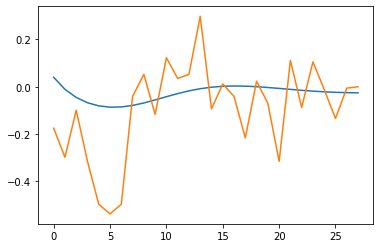

  0%|          | 0/4 [00:00<?, ?it/s]

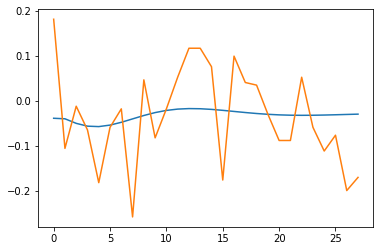

  0%|          | 0/4 [00:00<?, ?it/s]

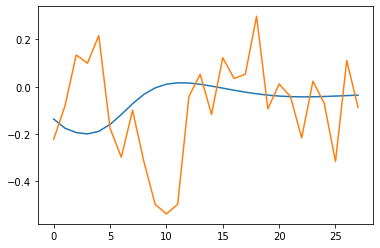

  0%|          | 0/4 [00:00<?, ?it/s]

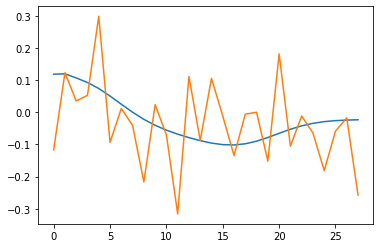

  0%|          | 0/4 [00:00<?, ?it/s]

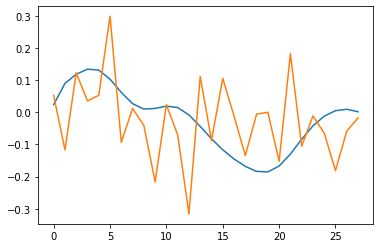

  0%|          | 0/4 [00:00<?, ?it/s]

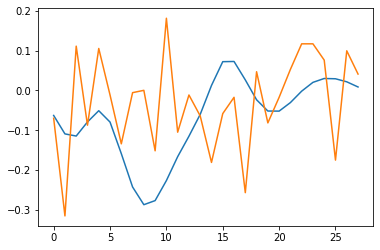

  0%|          | 0/4 [00:00<?, ?it/s]

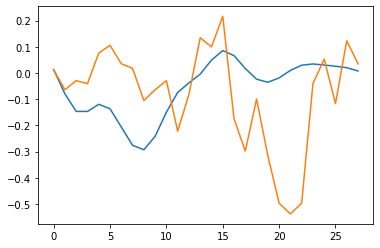

  0%|          | 0/4 [00:00<?, ?it/s]

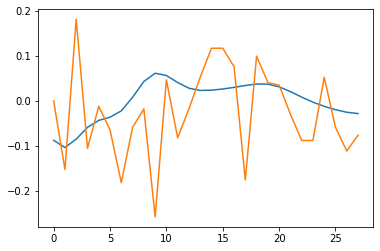

  0%|          | 0/4 [00:00<?, ?it/s]

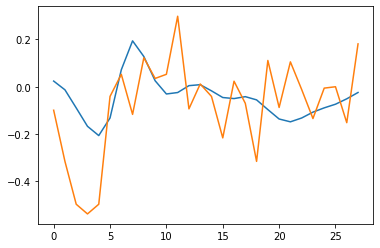

  0%|          | 0/4 [00:00<?, ?it/s]

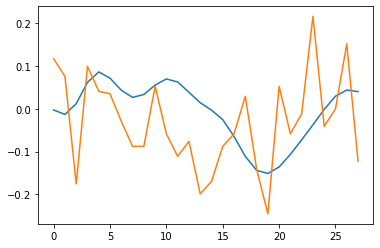

  0%|          | 0/4 [00:00<?, ?it/s]

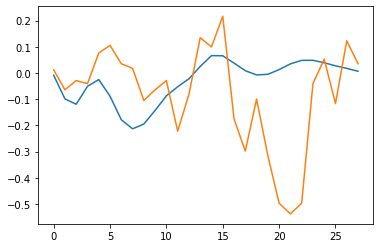

  0%|          | 0/4 [00:00<?, ?it/s]

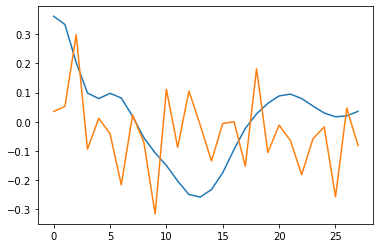

  0%|          | 0/4 [00:00<?, ?it/s]

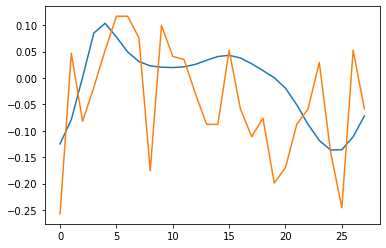

  0%|          | 0/4 [00:00<?, ?it/s]

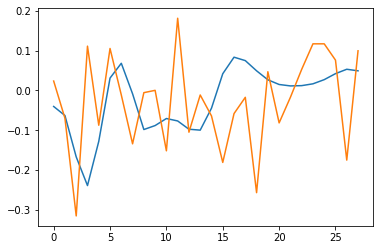

  0%|          | 0/4 [00:00<?, ?it/s]

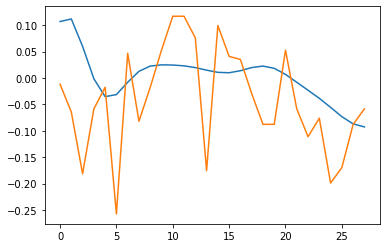

  0%|          | 0/4 [00:00<?, ?it/s]

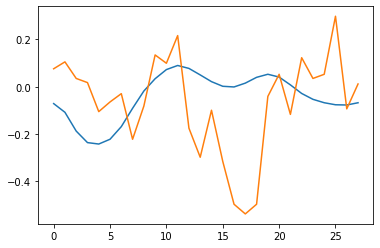

  0%|          | 0/4 [00:00<?, ?it/s]

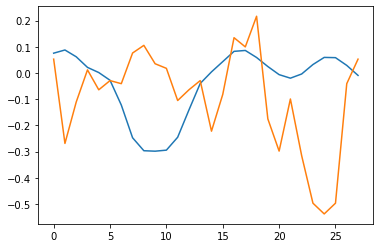

  0%|          | 0/4 [00:00<?, ?it/s]

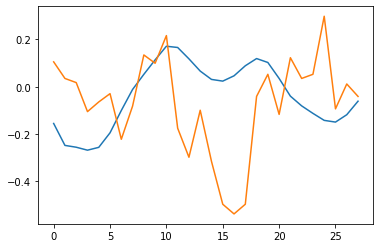

  0%|          | 0/4 [00:00<?, ?it/s]

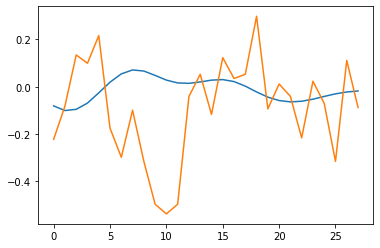

  0%|          | 0/4 [00:00<?, ?it/s]

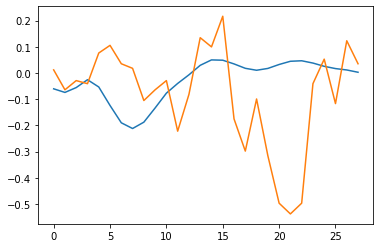

  0%|          | 0/4 [00:00<?, ?it/s]

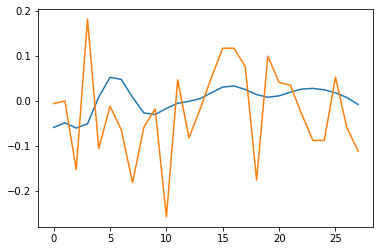

  0%|          | 0/4 [00:00<?, ?it/s]

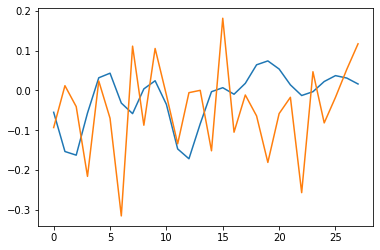

  0%|          | 0/4 [00:00<?, ?it/s]

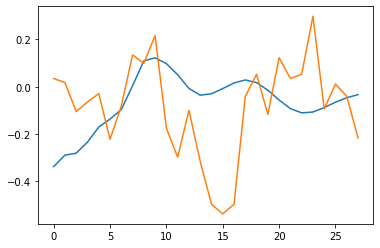

  0%|          | 0/4 [00:00<?, ?it/s]

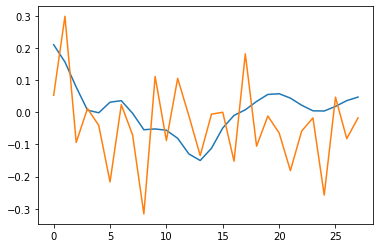

  0%|          | 0/4 [00:00<?, ?it/s]

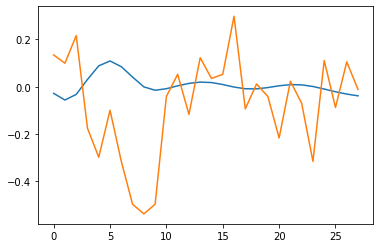

  0%|          | 0/4 [00:00<?, ?it/s]

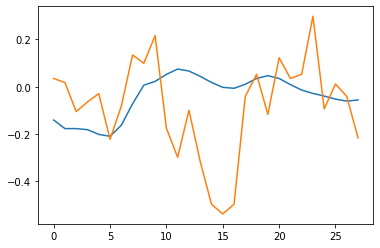

  0%|          | 0/4 [00:00<?, ?it/s]

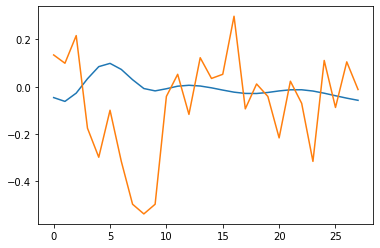

  0%|          | 0/4 [00:00<?, ?it/s]

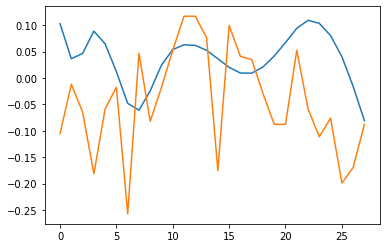

  0%|          | 0/4 [00:00<?, ?it/s]

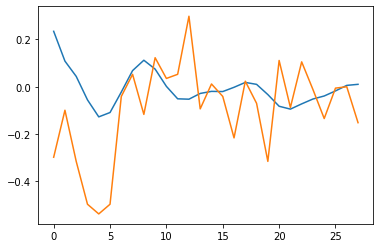

  0%|          | 0/4 [00:00<?, ?it/s]

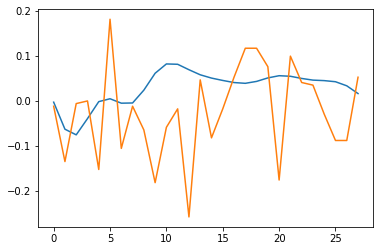

  0%|          | 0/4 [00:00<?, ?it/s]

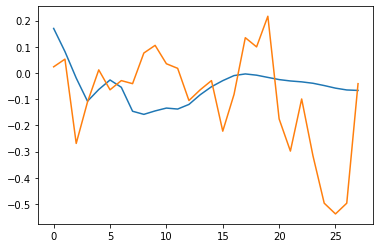

  0%|          | 0/4 [00:00<?, ?it/s]

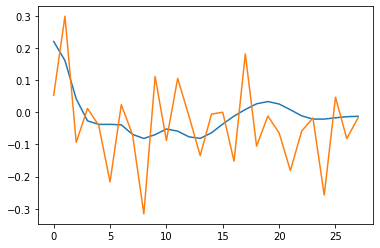

  0%|          | 0/4 [00:00<?, ?it/s]

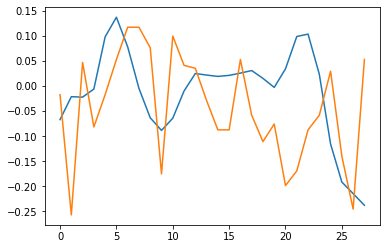

  0%|          | 0/4 [00:00<?, ?it/s]

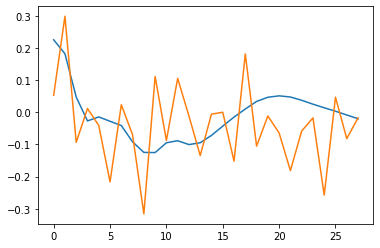

  0%|          | 0/4 [00:00<?, ?it/s]

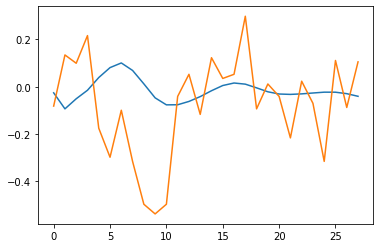

  0%|          | 0/4 [00:00<?, ?it/s]

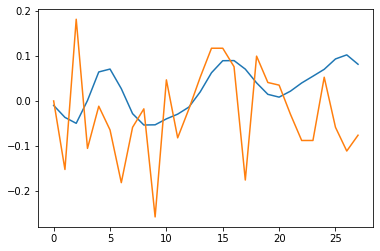

  0%|          | 0/4 [00:00<?, ?it/s]

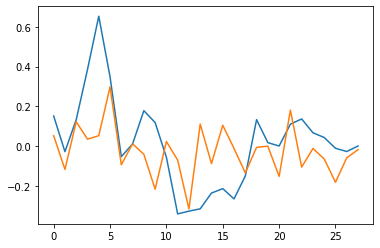

  0%|          | 0/4 [00:00<?, ?it/s]

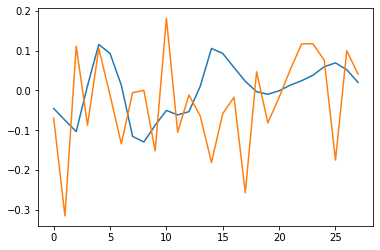

  0%|          | 0/4 [00:00<?, ?it/s]

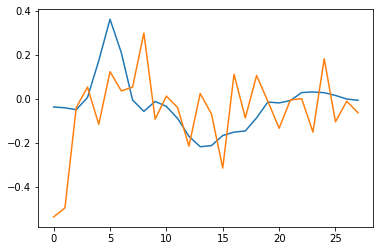

  0%|          | 0/4 [00:00<?, ?it/s]

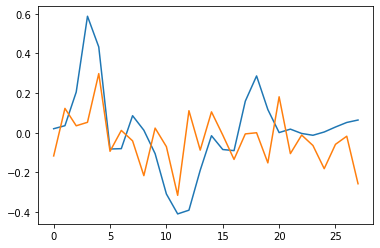

  0%|          | 0/4 [00:00<?, ?it/s]

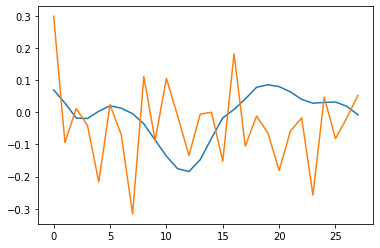

  0%|          | 0/4 [00:00<?, ?it/s]

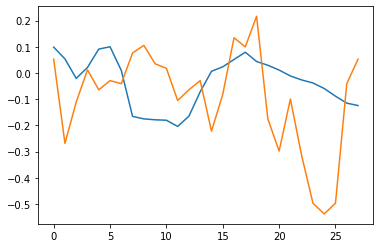

  0%|          | 0/4 [00:00<?, ?it/s]

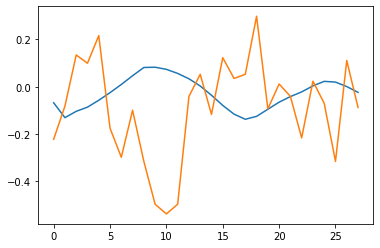

  0%|          | 0/4 [00:00<?, ?it/s]

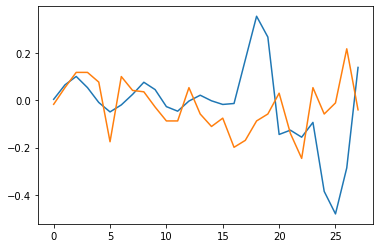

  0%|          | 0/4 [00:00<?, ?it/s]

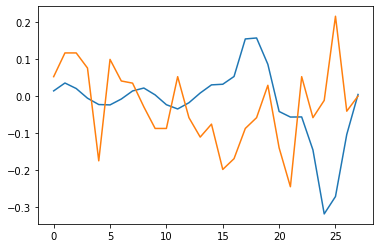

  0%|          | 0/4 [00:00<?, ?it/s]

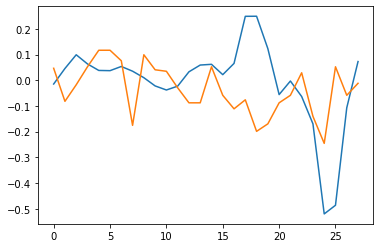

  0%|          | 0/4 [00:00<?, ?it/s]

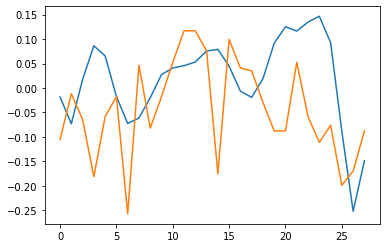

  0%|          | 0/4 [00:00<?, ?it/s]

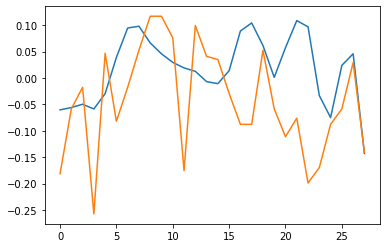

100%|██████████| 4/4 [00:00<00:00, 73.31it/s, loss=0.97, mode=validation, rmse=0.183]


In [127]:
train_dataset = WalmartDataset(
    features=train.values,
    targets=train.demand.values,
    train_window=TRAIN_WINDOW,
    predict_window=PREDICT_WINDOW,
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=TRAIN_BATCH_SIZE,
)

valid_dataset = WalmartDataset(
    features=valid.values,
    targets=valid.demand.values,
    train_window=TRAIN_WINDOW,
    predict_window=PREDICT_WINDOW,
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=VALID_BATCH_SIZE,
)

encoder = Encoder(NUM_FEATURES, HIDDEN_DIM).to(DEVICE)
attention = Attention(HIDDEN_DIM).to(DEVICE)
decoder = Decoder(HIDDEN_DIM, attention).to(DEVICE)

encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=1e-3)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)

criterion = nn.MSELoss().to(DEVICE)

for epoch in range(EPOCHS):
    train_loss = train_epoch(
        data_loader=train_loader,
        encoder=encoder,
        decoder=decoder, 
        criterion=criterion,
        encoder_optimizer=encoder_optimizer,
        decoder_optimizer=decoder_optimizer,
        device=DEVICE
    )
    valid_loss = validate_epoch(
        epoch=epoch,
        data_loader=valid_loader,
        encoder=encoder,
        decoder=decoder, 
        criterion=criterion,
        device=DEVICE
    )